<a href="https://colab.research.google.com/github/Deepak-desk/Deepak-desk/blob/main/zebracrossing_prediction_deep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

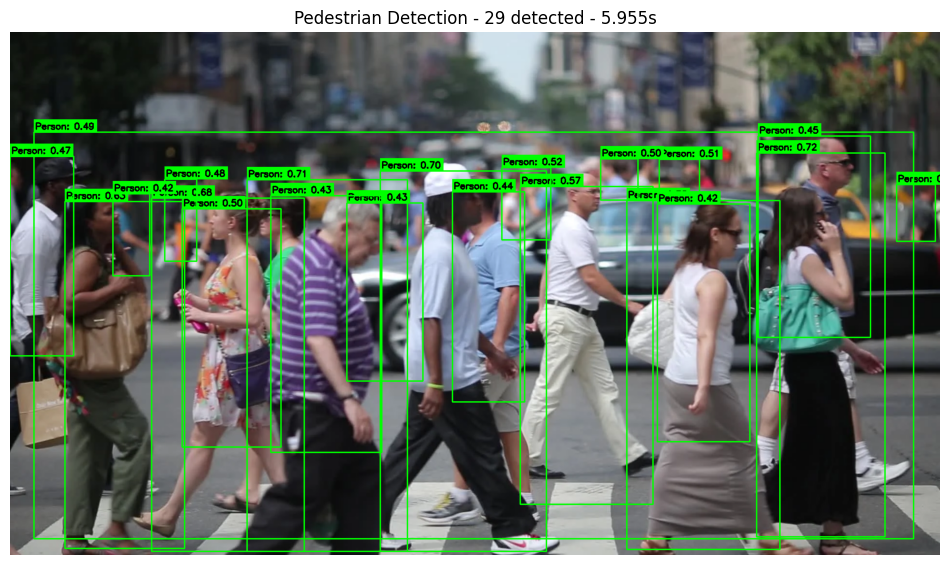

In [2]:
"""
Professional Pedestrian Detection System using TensorFlow Hub
Designed for high-performance inference and production deployment
"""

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List, Optional
import time
import logging
from dataclasses import dataclass
import json
import os

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger('PedestrianDetector')

@dataclass
class DetectionConfig:
    """Configuration for pedestrian detection"""
    score_threshold: float = 0.4
    nms_iou_threshold: float = 0.5
    pedestrian_class_id: int = 1
    model_handle: str = "https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2"
    max_output_size: int = 50
    inference_size: Optional[Tuple[int, int]] = None  # (width, height) or None for original size

@dataclass
class DetectionResult:
    """Structured detection results"""
    boxes: np.ndarray
    classes: np.ndarray
    scores: np.ndarray
    inference_time: float
    original_image_shape: Tuple[int, int]

    def to_dict(self) -> Dict:
        """Convert results to dictionary for serialization"""
        return {
            'boxes': self.boxes.tolist(),
            'classes': self.classes.tolist(),
            'scores': self.scores.tolist(),
            'inference_time': self.inference_time,
            'original_image_shape': self.original_image_shape
        }

    def save_json(self, file_path: str):
        """Save results to JSON file"""
        with open(file_path, 'w') as f:
            json.dump(self.to_dict(), f, indent=2)

class PedestrianDetector:
    """High-performance pedestrian detection system"""

    def __init__(self, config: DetectionConfig = None):
        self.config = config or DetectionConfig()
        self.detector = None
        self._load_model()

    def _load_model(self) -> None:
        """Load the detection model from TF-Hub"""
        logger.info("Loading detection model from TF-Hub...")
        start_time = time.time()

        try:
            self.detector = hub.load(self.config.model_handle)
            load_time = time.time() - start_time
            logger.info(f"Model loaded successfully in {load_time:.2f} seconds")
        except Exception as e:
            logger.error(f"Failed to load model: {str(e)}")
            raise

    def _preprocess_image(self, image: np.ndarray) -> np.ndarray:
        """Preprocess image for inference"""
        if self.config.inference_size:
            # Resize to specified inference size
            image = cv2.resize(image, self.config.inference_size)
        return image

    def _apply_nms(self, detection: Dict) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Apply Non-Maximum Suppression to filter detections"""
        boxes = detection['detection_boxes']
        classes = detection['detection_classes']
        scores = detection['detection_scores']

        # Apply NMS
        nms_indices = tf.image.non_max_suppression(
            boxes, scores,
            max_output_size=self.config.max_output_size,
            iou_threshold=self.config.nms_iou_threshold,
            score_threshold=self.config.score_threshold
        )

        # Gather filtered results
        nms_boxes = tf.gather(boxes, nms_indices).numpy()
        nms_classes = tf.gather(classes, nms_indices).numpy()
        nms_scores = tf.gather(scores, nms_indices).numpy()

        return nms_boxes, nms_classes, nms_scores

    def detect(self, image: np.ndarray) -> DetectionResult:
        """
        Run pedestrian detection on input image

        Args:
            image: Input image as numpy array (RGB format)

        Returns:
            DetectionResult object with detection data
        """
        if self.detector is None:
            raise RuntimeError("Detector not initialized. Call load_model() first.")

        # Store original shape
        original_shape = image.shape[:2]

        # Preprocess image
        processed_image = self._preprocess_image(image)

        # Prepare input tensor
        input_tensor = tf.convert_to_tensor(processed_image, dtype=tf.uint8)
        input_tensor = tf.expand_dims(input_tensor, 0)  # Add batch dimension

        # Run inference
        start_time = time.time()
        outputs = self.detector(input_tensor)
        inference_time = time.time() - start_time

        # Extract detection data
        detection = {
            'detection_boxes': outputs['detection_boxes'][0].numpy(),
            'detection_classes': outputs['detection_classes'][0].numpy().astype(np.int32),
            'detection_scores': outputs['detection_scores'][0].numpy()
        }

        # Apply NMS
        boxes, classes, scores = self._apply_nms(detection)

        return DetectionResult(
            boxes=boxes,
            classes=classes,
            scores=scores,
            inference_time=inference_time,
            original_image_shape=original_shape
        )

    @staticmethod
    def visualize_detections(
        image: np.ndarray,
        result: DetectionResult,
        config: DetectionConfig = None
    ) -> np.ndarray:
        """
        Draw detection boxes on image

        Args:
            image: Original image (will not be modified)
            result: Detection results
            config: Configuration for visualization

        Returns:
            Image with detection boxes drawn
        """
        config = config or DetectionConfig()
        image_with_boxes = image.copy()
        h, w = image.shape[:2]

        for box, cls, score in zip(result.boxes, result.classes, result.scores):
            # Filter based on score and class
            if score < config.score_threshold or int(cls) != config.pedestrian_class_id:
                continue

            # Convert normalized coordinates to pixel coordinates
            y1, x1, y2, x2 = box
            x1, x2 = int(x1 * w), int(x2 * w)
            y1, y2 = int(y1 * h), int(y2 * h)

            # Draw bounding box
            cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Create label with confidence score
            label = f"Person: {score:.2f}"

            # Calculate text size for background
            (text_w, text_h), baseline = cv2.getTextSize(
                label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2
            )

            # Draw text background
            cv2.rectangle(
                image_with_boxes,
                (x1, y1 - text_h - baseline - 6),
                (x1 + text_w + 6, y1),
                (0, 255, 0),
                -1
            )

            # Draw text
            cv2.putText(
                image_with_boxes,
                label,
                (x1 + 3, y1 - 6),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6,
                (0, 0, 0),
                2
            )

        return image_with_boxes

def load_image(image_path: str) -> np.ndarray:
    """
    Load image from file path

    Args:
        image_path: Path to image file

    Returns:
        Image as numpy array in RGB format
    """
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")

    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to read image from {image_path}")

    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def save_result(image: np.ndarray, output_path: str) -> None:
    """
    Save result image to file

    Args:
        image: Image to save (RGB format)
        output_path: Path to save image
    """
    # Convert to BGR for OpenCV save
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path, image_bgr)
    logger.info(f"Result saved to {output_path}")

def main(
    image_path: str = "zebracrossing.jpg",
    output_path: str = "detection_result.png",
    results_json_path: str = "detection_results.json",
    show_result: bool = True,
    save_output_image: bool = True
) -> Dict:
    """
    Main function to run pedestrian detection pipeline

    Args:
        image_path: Path to input image
        output_path: Path to save visualized result
        results_json_path: Path to save detection results as JSON
        show_result: Whether to display the result
        save_output_image: Whether to save the result image
    Returns:
        Dictionary with detection results and metadata
    """
    try:
        # Initialize detector with custom configuration
        config = DetectionConfig(
            score_threshold=0.4,
            nms_iou_threshold=0.5,
            inference_size=(640, 480)  # Optimized for speed
        )

        detector = PedestrianDetector(config)

        # Load image
        logger.info(f"Loading image from {image_path}")
        image = load_image(image_path)

        # Run detection
        logger.info("Running pedestrian detection...")
        result = detector.detect(image)

        # Visualize results
        logger.info("Visualizing detection results...")
        result_image = detector.visualize_detections(image, result, config)

        # Save results
        if save_output_image:
            save_result(result_image, output_path)
            result.save_json(results_json_path)

        # Display results
        if show_result:
            plt.figure(figsize=(12, 8))
            plt.axis('off')
            plt.imshow(result_image)
            plt.title(f"Pedestrian Detection - {len(result.boxes)} detected - {result.inference_time:.3f}s")
            plt.show()

        # Log performance metrics
        pedestrian_count = np.sum(
            (result.classes == config.pedestrian_class_id) &
            (result.scores >= config.score_threshold)
        )

        logger.info(
            f"Detection completed: {pedestrian_count} pedestrians detected "
            f"in {result.inference_time:.3f} seconds"
        )

        return {
            'image_path': image_path,
            'pedestrian_count': int(pedestrian_count),
            'inference_time': result.inference_time,
            'detection_results': result.to_dict()
        }

    except Exception as e:
        logger.error(f"Error in detection pipeline: {str(e)}")
        raise

if __name__ == "__main__":
    # Example usage with different images
    image_files = ["crowd.jpg"]

    for image_file in image_files:
        if os.path.exists(image_file):
            result_file = f"result_{image_file}"
            json_file = f"results_{os.path.splitext(image_file)[0]}.json"

            try:
                main(
                    image_path=image_file,
                    output_path=result_file,
                    results_json_path=json_file,
                    show_result=True,
                    save_output_image=True
                )
            except Exception as e:
                logger.error(f"Failed to process {image_file}: {str(e)}")
        else:
            logger.warning(f"Image file not found: {image_file}")